
# Classification of PubMed texts using sparse features with SciKit-Learn


This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

Using this example, we are building a "liver cancer text classifier".



In [0]:

# Author: Kyubum Lee
# Based on 'SciKit-Learn - Classification of text documents using sparse features' from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

#!pip install numpy
#!pip install sklearn
#!pip install matplotlib

%matplotlib inline

import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt
import requests
from xml.etree import ElementTree
import random, re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics



# Loading Necessary Functions
(You don't have to understand this part.)


In [0]:
def get_pmids_for_edat_and_query(start_edat, end_edat, query_term = False, ncbi_api_key = False):
    print("[Getting PMIDs for selected EDAT] Getting all the PMIDs from EDAT %s to %s" % (start_edat, end_edat))
    if (type(start_edat) != str):
        start_edat = str(start_edat)
    if (type(end_edat) != str):
        end_edat = str(end_edat)

    if ((len(start_edat) != 8) | (len(end_edat) != 8)):
        print('Wrong EDAT formats!!!! \n Start_EDAT and END_EDAT should have YYYYMMDD format.')
        print('Your input: Start_EDAT : %s , End_EDAT : %s' % (start_edat, end_edat))
        sys.exit("====> Stopping the program.")
        #raise ModelTrainingException("Wrong EDAT formats!!!! \n Start_EDAT and END_EDAT should have YYYYMMDD format.")
    elif (int(start_edat) > int(end_edat)):
        print('Your input: Start_EDAT : %s , End_EDAT : %s' % (start_edat, end_edat))
        print('Start Date should be earlier than End Date')
        sys.exit("====> Stopping the program.")
        #raise ModelTrainingException("Start Date should be earlier than End Date. Your input: Start_EDAT : %s , End_EDAT : %s" % (start_edat, end_edat))

    start_year = start_edat[0:4]
    end_year = end_edat[0:4]
    start_month = start_edat[4:6]
    end_month = end_edat[4:6]
    start_date = start_edat[6:]
    end_date = end_edat[6:]

    if query_term:
      if ncbi_api_key == True:
          URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&api_key="+ncbi_api_key+"&term=("+query_term+")%20AND%20((\"" + start_year + "/" + start_month + "/" + start_date + "\"[EDAT]:\"" + end_year + "/" + end_month + "/" + end_date + "\"[EDAT])&retmax=40000000"
      else:
          URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=("+query_term+")%20AND%20((\"" + start_year + "/" + start_month + "/" + start_date + "\"[EDAT]:\"" + end_year + "/" + end_month + "/" + end_date + "\"[EDAT])&retmax=40000000"
    else:
      if ncbi_api_key == True:
          URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&api_key="+ncbi_api_key+"&term=((\"" + start_year + "/" + start_month + "/" + start_date + "\"[EDAT]:\"" + end_year + "/" + end_month + "/" + end_date + "\"[EDAT])&retmax=40000000"
      else:
          URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=((\"" + start_year + "/" + start_month + "/" + start_date + "\"[EDAT]:\"" + end_year + "/" + end_month + "/" + end_date + "\"[EDAT])&retmax=40000000"

    print(URL)
    raw_xml = url_to_content(URL)
    pmids = xml_to_pmids(raw_xml)
    return pmids

def url_generation(pmids, max_pmids):
    urls = []
    pmids_used_counter = 0
    while pmids_used_counter < len(pmids):
        temp_query = ''
        temp_query_counter = 0
        while ((temp_query_counter < max_pmids) & (pmids_used_counter < len(pmids))):
            if (pmids_used_counter % max_pmids) == 0:
                temp_query = str(pmids[pmids_used_counter])
            else:
                temp_query = temp_query + '+' + str(pmids[pmids_used_counter])
            pmids_used_counter = pmids_used_counter + 1
            temp_query_counter = temp_query_counter + 1
        base_url_temp = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id=" + temp_query + "&retmode=xml"
        urls.append(base_url_temp)
    return urls


def url_to_content(url):
    response = requests.get(url, timeout=10000)

    if '[200]' in response:
        print(url)
        print('response : %s' % response)
        sleep_time = 100
        print("Retrying in %s seconds." % sleep_time)
        time.sleep(sleep_time)  # seconds

    return response.content

def xml_to_pmids(xml_raw):
    pmids = []
    xml_raw = preprocess_xml(xml_raw)
    root = ElementTree.fromstring(xml_raw)
    for child in root:  # PubmedArticle OR PubmedBookArticle
        if child.tag == "Count":
            pmid_count = child.text
            print('Total PMIDs : %s ' % pmid_count)
        elif child.tag == "IdList":
            for gchild in child:
                if gchild.tag == "Id":
                    pmids.append(gchild.text)

    return pmids

def preprocess_xml(raw_xml):
    xml_raw = raw_xml
    xml_raw = raw_xml.decode('utf-8').strip()
    # xml_raw = xml_raw.encode('ascii', 'ignore')
    # xml_raw = xml_raw.encode('utf-8')
    xml_raw = xml_raw.replace('<i>', "")
    xml_raw = xml_raw.replace('</i>', "")
    xml_raw = xml_raw.replace('<inv>', "")
    xml_raw = xml_raw.replace('</inv>', "")
    xml_raw = xml_raw.replace('<b>', "")
    xml_raw = xml_raw.replace('</b>', "")
    xml_raw = xml_raw.replace('<sup>', "")
    xml_raw = xml_raw.replace('</sup>', "")
    xml_raw = xml_raw.replace('<sub>', "")
    xml_raw = xml_raw.replace('</sub>', "")
    xml_raw = xml_raw.replace('&nbsp', " ")
    xml_raw = xml_raw.replace('\n', " ")
    while xml_raw.find("  ") != -1:
        xml_raw = xml_raw.replace("  ", " ")
    return xml_raw

################From here for Get Pubmed info ######################
def get_pubmed_text_for_pmids(pmids_list):
    # take a pmid list as an input, and return a string of processed articles
    sleep_time = 5
    max_pmids = 100
    print('Changing %s PMIDs to articles.' % len(pmids_list))

    all_urls = url_generation(pmids_list, max_pmids)
    return_articles = ''
    counter = 0
    last_progress = -1
    for url1 in all_urls:
        progress = int((counter * 100) / len(all_urls))
        if progress != last_progress:
            print('Retrieving Article Information from PubMed : %d %%' % progress)
            last_progress = progress
        counter = counter + 1
        try:
            returned_xml = url_to_content(url1)
            temp_articles = xml_to_text(returned_xml)
            return_articles = return_articles + temp_articles
        except Exception as error_msg:
            print('error')
            print(error_msg)
            print(url1)
            print('Re-trying in %s seconds' % sleep_time)
            time.sleep(sleep_time)
            try:
                returned_xml = url_to_content(url1)
                temp_articles = xml_to_text(returned_xml)

                return_articles = return_articles + temp_articles
            except:
                print('error')
                print(url1)
                sleep_time = sleep_time * 2
                print('Re-trying in %s seconds' % sleep_time)
                time.sleep(sleep_time)
                try:
                    returned_xml = url_to_content(url1)
                    temp_articles = xml_to_text(returned_xml)
                    return_articles = return_articles + temp_articles
                except:
                    print('error')
                    print(url1)
    return return_articles


def xml_to_text(raw_xml):
    xml_raw = preprocess_xml(raw_xml)
    parsed_articles = ''
    root = ElementTree.fromstring(xml_raw)
    for child in root:  # PubmedArticle OR PubmedBookArticle
        _pmid = ''
        _edat = ''
        _journal_title = ''
        _article_types = ''
        _abstract = ''
        _title = ''
        vtitle = ''
        regtitle = ''
        lang = ''

        for gchild in child:
            if gchild.tag == "MedlineCitation":
                pmid = gchild.find('PMID').text
                for ggchild in gchild:
                    if ggchild.tag == "Article":
                        for gggchild in ggchild:
                            if gggchild.tag == "Journal":
                                if gggchild.find('ISOAbbreviation') != None:
                                    journal_title = str(gggchild.find('ISOAbbreviation').text)
                                elif gggchild.find('Journal') != None:
                                    journal_title = str(gggchild.find('Journal').text)
                                elif gggchild.find('Title') != None:
                                    journal_title = str(gggchild.find('Title').text)
                                else:
                                    print('No Journal Info for this article PMID %s' % pmid)

                                _journal_title = journal_title.replace(' ', '_')
                            if gggchild.tag == "ArticleTitle":
                                _title = gggchild.text
                            if gggchild.tag == "VernacularTitle":
                                vtitle = gggchild.text
                            if gggchild.tag == "Title":
                                regtitle = gggchild.text

                            if gggchild.tag == "Abstract":
                                for ggggchild in gggchild.findall('AbstractText'):
                                    _abstract = _abstract + str(ggggchild.text) + ' '
                            if gggchild.tag == "PublicationTypeList":
                                for ggggchild in gggchild.findall('PublicationType'):
                                    _article_types = _article_types + ggggchild.attrib['UI'] + ' '
                            if gggchild.tag == "Language":
                                lang = gggchild.text

            if gchild.tag == "PubmedData":
                for ggchild in gchild:
                    if ggchild.tag == "History":
                        for gggchild in ggchild:
                            tempstr = gggchild.attrib['PubStatus']
                            if 'entrez' in tempstr:
                                year = gggchild.find('Year').text
                                month = gggchild.find('Month').text
                                if len(month) == 1:
                                    month = '0' + month
                                day = gggchild.find('Day').text
                                if len(day) == 1:
                                    day = '0' + day
                                _edat = year + month + day

                    if ggchild.tag == "ArticleIdList":
                        for gggchild in ggchild:
                            tempstr = gggchild.attrib['IdType']
                            if 'pubmed' in tempstr:
                                _pmid = gggchild.text

        if _title == '':
            _title = vtitle

        if (_title != None) & (_abstract != ''):
            current_article = _pmid + "\t" + _edat + "\t" + _journal_title + "\t" + _article_types + "\t" + lang + "\t" + _title + "\t" + _abstract
            parsed_articles = parsed_articles + current_article + "\n"
    
    return parsed_articles

def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def shuffle_two_list(list_a, list_b):
    return_list_a = []
    return_list_b = []
    if len(list_a) != len(list_b):
        logger.error("The length of the input lists are different")
        sys.exit()
        #raise ModelTrainingException("The length of the input lists are different")
    else:
        list_num = range(len(list_a))
        list_num_shuffle = random.sample(list_num, len(list_num))
        for i in list_num_shuffle:
            return_list_a.append(list_a[i])
            return_list_b.append(list_b[i])
        return return_list_a, return_list_b

def load_data_and_labels(positive_texts, negative_texts):
    x_text = positive_texts + negative_texts
    x_text = [clean_str(sent) for sent in x_text]

    positive_labels = [1 for _ in positive_texts]
    negative_labels = [0 for _ in negative_texts]

    y = np.concatenate([positive_labels, negative_labels], 0)
    x_text, y = shuffle_two_list(x_text, y)
    np_x_text = np.asarray(x_text)
    np_y = np.asarray(y)
    return [np_x_text, np_y]
  


Collect data from PubMed 
------------------------------------
Let's download publications that are related to "Liver Neoplasms[MeSH Terms]" and published between 2019 Jan and June. We are going to use a subset of these publication as positive data. We are also retrieving random articles and use them as negative data. 





In [16]:
# Target publication period and the search term
start_date = "20190101"
end_date = "20190630"
query_term="\"liver%20neoplasms\"%5BMeSH%20Terms%5D"
howmany_positive_to_use = 3000


#Collect Positive PMIDs
pos_pmids_all = get_pmids_for_edat_and_query(start_date, end_date, query_term)
print("%s PMIDs are retrieved" % len(pos_pmids_all))


#Collect Negative PMIDs
neg_pmids_temp = get_pmids_for_edat_and_query(start_date, end_date)
print("%s PMIDs are retrieved" % len(neg_pmids_temp))
neg_pmids_all = [x for x in neg_pmids_temp if x not in pos_pmids_all]

print("Positive PMIDs (all): %s" % len(pos_pmids_all))
print("Negative PMIDs (all): %s" % len(neg_pmids_all))


# Shuffling the PMIDs
random.shuffle(pos_pmids_all)
random.shuffle(neg_pmids_all)

# Sampling negative as the same number as positive
pos_num = min(len(pos_pmids_all), howmany_positive_to_use)
pos_pmids = pos_pmids_all[:pos_num]
neg_pmids = random.sample(neg_pmids_all, len(pos_pmids*2))

print("Positive PMIDs to use: %s" % len(pos_pmids))
print("Negative PMIDs to use: %s" % len(neg_pmids))



[Getting PMIDs for selected EDAT] Getting all the PMIDs from EDAT 20190101 to 20190630
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=("liver%20neoplasms"%5BMeSH%20Terms%5D)%20AND%20(("2019/01/01"[EDAT]:"2019/06/30"[EDAT])&retmax=40000000
Total PMIDs : 2327 
2327 PMIDs are retrieved
[Getting PMIDs for selected EDAT] Getting all the PMIDs from EDAT 20190101 to 20190630
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(("2019/01/01"[EDAT]:"2019/06/30"[EDAT])&retmax=40000000
Total PMIDs : 611468 
611468 PMIDs are retrieved
Positive PMIDs (all): 2327
Negative PMIDs (all): 609141
Positive PMIDs to use: 2327
Negative PMIDs to use: 4654



# Collecting Texts for PMIDs from PubMed

In [17]:
print("Retrieving Positive Articles")
pos_texts = get_pubmed_text_for_pmids(pos_pmids).split("\n")
print("Retrieving Negative Articles")
neg_texts = get_pubmed_text_for_pmids(neg_pmids).split("\n")

print("\nPositive Articles Examples:\n")
print(*pos_texts[:3], sep = "\n")
print("\nNegative Articles Examples:\n")
print(*neg_texts[:3], sep = "\n")


Retrieving Positive Articles
Changing 2327 PMIDs to articles.
Retrieving Article Information from PubMed : 0 %
Retrieving Article Information from PubMed : 4 %
Retrieving Article Information from PubMed : 8 %
Retrieving Article Information from PubMed : 12 %
Retrieving Article Information from PubMed : 16 %
Retrieving Article Information from PubMed : 20 %
Retrieving Article Information from PubMed : 25 %
Retrieving Article Information from PubMed : 29 %
Retrieving Article Information from PubMed : 33 %
Retrieving Article Information from PubMed : 37 %
Retrieving Article Information from PubMed : 41 %
Retrieving Article Information from PubMed : 45 %
Retrieving Article Information from PubMed : 50 %
Retrieving Article Information from PubMed : 54 %
Retrieving Article Information from PubMed : 58 %
Retrieving Article Information from PubMed : 62 %
Retrieving Article Information from PubMed : 66 %
Retrieving Article Information from PubMed : 70 %
Retrieving Article Information from PubMe

# Separating the data into Train / Val / Test




In [18]:
# Train : Val : Test = 8 : 1 : 1
p = len(pos_texts)//10
pos_train_texts = pos_texts[p*2:]
pos_val_texts = pos_texts[p:p*2]
pos_test_texts = pos_texts[:p]

n = len(neg_texts)//10
neg_train_texts = neg_texts[n*2:]
neg_val_texts = neg_texts[n:n*2]
neg_test_texts = neg_texts[:n]

print("Positive Train, Val, Test: %s, %s, %s" % (len(pos_train_texts),len(pos_val_texts),len(pos_test_texts)))
print("Negative Train, Val, Test: %s, %s, %s" % (len(neg_train_texts),len(neg_val_texts),len(neg_test_texts)))

# Mix Positive and Negatives
x_train, y_train = load_data_and_labels(pos_train_texts, neg_train_texts)
x_val, y_val = load_data_and_labels(pos_val_texts, neg_val_texts)
x_test, y_test = load_data_and_labels(pos_test_texts, neg_test_texts)


Positive Train, Val, Test: 1699, 212, 212
Negative Train, Val, Test: 3239, 404, 404


# Feature extraction 
Changing text data (non-structured) into features (structured)

In [0]:

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.9, stop_words='english', ngram_range=(1, 2), min_df=3)
x_train_vec = vectorizer.fit_transform(x_train)
x_val_vec = vectorizer.transform(x_val)
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)


Benchmark classifiers
------------------------------------
We train and test the datasets with 13 different classification models
and get performance results for each model.



In [20]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train_vec, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_val_vec)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_val, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

def classify(clf, x_vec_input, y_input):
  print('_' * 80)
  clf_descr = str(clf).split('(')[0]
  print("Predicting with %s" % clf_descr)
  pred = clf.predict(x_vec_input)
  score = metrics.accuracy_score(y_input, pred)
  return clf_descr, score

results = []
trained_clfs = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest"), # Random forest
        (LinearSVC(penalty="l2", dual=False, tol=1e-3), "LinearSVC with l2" ), #LinearSVC with l2
        (LinearSVC(penalty="l1", dual=False, tol=1e-3), "LinearSVC with l1" ), #LinearSVC with l1
        (SGDClassifier(alpha=.0001, max_iter=50, penalty="l2"), "SGD with l2" ), #SGD with l2
        (SGDClassifier(alpha=.0001, max_iter=50, penalty="l1"), "SGD with l1"), #SGD with l1 
        (SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet"), "SGD with Elastic Net penalty"), #SGD with Elastic Net penalty
        (NearestCentroid(), "NearestCentroid"), #NearestCentroid (aka Rocchio classifier)
        (MultinomialNB(alpha=.01), "Naive Bayes - Multinomial"),
        (BernoulliNB(alpha=.01), "Naive Bayes - Bernoulli"),
        (ComplementNB(alpha=.01), "Naive Bayes - Complement"),
        ):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    trained_clfs.append(clf)


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.123s
test time:  0.001s
accuracy:   0.963

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.019s
test time:  0.001s
accuracy:   0.955

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                        

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 0.005s
test time:  0.254s
accuracy:   0.899

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train time: 4.009s
test time:  0.062s
accuracy:   0.964

LinearSVC with l2
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', ma

Add plots
------------------------------------
The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



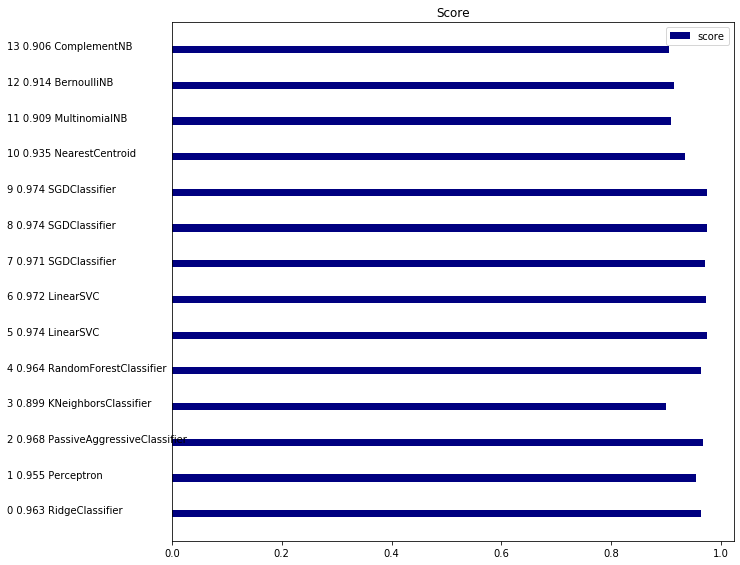

In [21]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results


plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')

plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, s, c in zip(indices, score, clf_names):
    temp_str = "%.3f %s" % (s,c)
    plt.text(-.3, i, temp_str)

plt.show()

# Evaluate the classifiers using test set
We already made the test data in the previous section: x_test, y_test = load_data_and_labels(pos_test_texts, neg_test_texts)
We change this texts into features using the same vectorizer we made.

In [22]:
plt.clf()

# Change the text to vector using the same vectorizer that we made previously
x_test_vec = vectorizer.transform(x_test)

clf_names_test = []
clf_scores_test = []
for clf in trained_clfs:
  clf_name, clf_score = classify(clf, x_test_vec, y_test)
  clf_names_test.append(clf_name)
  clf_scores_test.append(clf_score)


________________________________________________________________________________
Predicting with RidgeClassifier
________________________________________________________________________________
Predicting with Perceptron
________________________________________________________________________________
Predicting with PassiveAggressiveClassifier
________________________________________________________________________________
Predicting with KNeighborsClassifier
________________________________________________________________________________
Predicting with RandomForestClassifier
________________________________________________________________________________
Predicting with LinearSVC
________________________________________________________________________________
Predicting with LinearSVC
________________________________________________________________________________
Predicting with SGDClassifier
________________________________________________________________________________
Predicting

<Figure size 432x288 with 0 Axes>

# See the evaluation plot for the test set


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


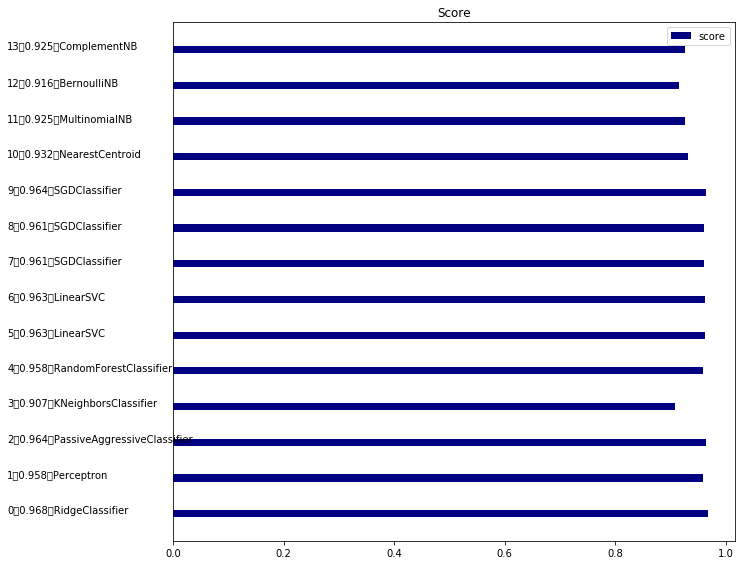

In [23]:

indices = list(range(len(clf_names_test)))

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, clf_scores_test, .2, label="score", color='navy')
# plt.barh(indices + .3, training_time, .2, label="training time", color='c')
# plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, s, c in zip(indices, clf_scores_test, clf_names_test):
    temp_str = "%.3f %s" % (s,c)
    plt.text(-.3, i, temp_str)

plt.show()

# Collect New Publications and classify them with our trained classifier


1.   Download all the publication that are published on March 1.
2.   Change the texts to features using the vectorizer.
3.   See how many of them are classified as positives.


In [24]:
# Collect New Publications and classify them with our trained classifier

selected_clf_index = 4

start_date = "20200301"
end_date = "20200301"
target_pmids = get_pmids_for_edat_and_query(start_date, end_date)

print("Retrieving Positive Articles")
target_texts = get_pubmed_text_for_pmids(target_pmids).split("\n")
target_vec = vectorizer.transform(target_texts)

selected_clf = trained_clfs[selected_clf_index]
target_pred = selected_clf.predict(target_vec)

#printing positive articles
pos_num = 0
for i in range(len(target_pred)):
  if target_pred[i] == 1:
    print(target_texts[i])
    pos_num += 1

print("%d / %d are positive" % (pos_num, len(target_pred)))



[Getting PMIDs for selected EDAT] Getting all the PMIDs from EDAT 20200225 to 20200225
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(("2020/02/25"[EDAT]:"2020/02/25"[EDAT])&retmax=40000000
Total PMIDs : 3815 
Retrieving Positive Articles
Changing 3815 PMIDs to articles.
Retrieving Article Information from PubMed : 0 %
Retrieving Article Information from PubMed : 2 %
Retrieving Article Information from PubMed : 5 %
Retrieving Article Information from PubMed : 7 %
Retrieving Article Information from PubMed : 10 %
Retrieving Article Information from PubMed : 12 %
Retrieving Article Information from PubMed : 15 %
Retrieving Article Information from PubMed : 17 %
Retrieving Article Information from PubMed : 20 %
Retrieving Article Information from PubMed : 23 %
Retrieving Article Information from PubMed : 25 %
Retrieving Article Information from PubMed : 28 %
Retrieving Article Information from PubMed : 30 %
Retrieving Article Information from PubMed : 33 %
Retr

You can see more examples at: https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

# Additional Information:

* You can see more examples at: https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
* Use MeSH to Build a Better PubMed Query (Video): https://www.ncbi.nlm.nih.gov/books/NBK121324/
* Literature mining (Text classification) tutorials:
https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
* “Scaling up data curation using deep learning: An application to literature triage in genomic variation resources” PLOS Computational Biology (2018) https://doi.org/10.1371/journal.pcbi.1006390


# Literature Search Engines:
* PubMed https://www.ncbi.nlm.nih.gov/pubmed
* PubMed Labs https://www.ncbi.nlm.nih.gov/labs/pubmed/
* Semantic Scholar https://www.semanticscholar.org/
* MeSH https://www.ncbi.nlm.nih.gov/mesh
* PubMed Advanced Search https://www.ncbi.nlm.nih.gov/mesh/advanced
* EuropePMC http://europepmc.org/



